<a href="https://colab.research.google.com/github/fedllanes/flight_delay/blob/main/flight_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
%cd /content/drive/My Drive/Colab Notebooks/Airport

/content/drive/My Drive/Colab Notebooks/Airport


The data used is from Kaggle.
https://www.kaggle.com/usdot/flight-delays

# Context
The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

# Acknowledgements
The flight delay and cancellation data was collected and published by the DOT's Bureau of Transportation Statistics.

The original dataset is massive, we will be using exactly 1 percent of it

# Objectives 

The goal of the project is being able to visualize the data to gain some insight into US flights, and information related to delays in particular.

We will also try to train a model to predict flight delays.

In [56]:
import pandas as pd
import numpy as np

In [57]:
airports = pd.read_csv("airports.csv")
flights = pd.read_csv("flights.csv") 
planes = pd.read_csv("planes.csv")
new = pd.read_csv("new.csv")
airlines = pd.read_csv("airlines.csv")
airports2 = pd.read_csv("airports2.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# ANALYSIS OF THE DIFFERENT DATAFRAMES.

In [58]:
#Information about the airports, we will be using the name of the airport
airports.head(2)

faa                           name        lat  ...  tz  dst             tzone
0  04G              Lansdowne Airport  41.130472  ...  -5    A  America/New_York
1  06A  Moton Field Municipal Airport  32.460572  ...  -6    A   America/Chicago

[2 rows x 8 columns]

In [59]:
#From this dataset we will be getting the manufacturer name.
planes.head(2) 

tailnum    year                     type  ... seats speed     engine
0  N10156  2004.0  Fixed wing multi engine  ...    55   NaN  Turbo-fan
1  N102UW  1998.0  Fixed wing multi engine  ...   182   NaN  Turbo-fan

[2 rows x 9 columns]

In [60]:
#Here we care about the name of the airlines, to not use the acronym
airlines.head(2)

carrier                    name
0      9E       Endeavor Air Inc.
1      AA  American Airlines Inc.

In [61]:
#Information about the airports, we will be using the city where the airports are located
airports2.head(2)

IATA_CODE                              AIRPORT  ...  LATITUDE LONGITUDE
0       ABE  Lehigh Valley International Airport  ...  40.65236  -75.4404
1       ABI             Abilene Regional Airport  ...  32.41132  -99.6819

[2 rows x 7 columns]

In [62]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

The dataset is quite big, with almost 6 million entries and weighting 1.3GB in memory

Most columns have very little nonnull values, which is not a problem for us, since we could remove that small percentage, but the columns after CANCELLATION_REASON are mostly null, so we will get rid of them completely.

In [63]:
flights.head().T

0       1       2       3       4
YEAR                   2015    2015    2015    2015    2015
MONTH                     1       1       1       1       1
DAY                       1       1       1       1       1
DAY_OF_WEEK               4       4       4       4       4
AIRLINE                  AS      AA      US      AA      AS
FLIGHT_NUMBER            98    2336     840     258     135
TAIL_NUMBER          N407AS  N3KUAA  N171US  N3HYAA  N527AS
ORIGIN_AIRPORT          ANC     LAX     SFO     LAX     SEA
DESTINATION_AIRPORT     SEA     PBI     CLT     MIA     ANC
SCHEDULED_DEPARTURE       5      10      20      20      25
DEPARTURE_TIME         2354       2      18      15      24
DEPARTURE_DELAY         -11      -8      -2      -5      -1
TAXI_OUT                 21      12      16      15      11
WHEELS_OFF               15      14      34      30      35
SCHEDULED_TIME          205     280     286     285     235
ELAPSED_TIME            194     279     293     281     215
AIR_TIME                169     263     266     258     199
DISTANCE               1448    2330    2296    2342    1448
WHEELS_ON               404     737     800     748     254
TAXI_IN                   4       4      11       8       5
SCHEDULED_ARRIVAL       430     750     806     805     320
ARRIVAL_TIME            408     741     811     756     259
ARRIVAL_DELAY           -22      -9       5      -9     -21
DIVERTED                  0       0       0       0       0
CANCELLED                 0       0       0       0       0
CANCELLATION_REASON     NaN     NaN     NaN     NaN     NaN
AIR_SYSTEM_DELAY        NaN     NaN     NaN     NaN     NaN
SECURITY_DELAY          NaN     NaN     NaN     NaN     NaN
AIRLINE_DELAY           NaN     NaN     NaN     NaN     NaN
LATE_AIRCRAFT_DELAY     NaN     NaN     NaN     NaN     NaN
WEATHER_DELAY           NaN     NaN     NaN     NaN     NaN

There are some interesting facts about this dataset, for instance, the date of departure is represented on three different columns, "Year", "Month" and "Day" which we will later on convert to a datatime element, the departure time is also expressed with 2 to 4 digits, we will leave it as it is.

## MERGING THE DATAFRAMES

## We will merge the different datasets to get the information we need.

In [64]:
flights = pd.merge(flights,airports[["faa","name"]],left_on="ORIGIN_AIRPORT",right_on="faa",how="left")
flights.rename(columns={'name': 'origin_airport'}, inplace=True)
flights = flights.drop("faa",axis=1)

In [65]:
flights = pd.merge(flights,airports2[["IATA_CODE","CITY"]],left_on="ORIGIN_AIRPORT",right_on="IATA_CODE",how="left")
flights.rename(columns={'name': 'city'}, inplace=True)
flights = flights.drop("IATA_CODE",axis=1)

In [66]:
flights = pd.merge(flights,planes[["tailnum","manufacturer"]],left_on="TAIL_NUMBER",right_on="tailnum",how="left")
flights = flights.drop("tailnum",axis=1)

In [67]:
flights = pd.merge(flights,airlines,left_on="AIRLINE",right_on="carrier",how="left")
flights = flights.drop("carrier",axis=1)
flights.rename(columns={'name': 'AIRLINE_NAME'}, inplace=True)

## Creating new columns
We will create two columns, a boolean delay which tells us wether the plane was delayed or not, and another one which tell us the delay time, we have to consider delay times can be negative, but we don't care about those, we will consider the negative delay times as no delay

In [68]:
flights["Delay"] = flights["ARRIVAL_DELAY"].apply(lambda x: True if x>0 else False)
flights["Delay_time"] = flights["ARRIVAL_DELAY"].apply(lambda x: x if x>0 else 0)

In [69]:
import datetime
import math

## Dealing with dates 
Converting the the date columns into a datatime element and then a dayoftheyear, dayoftheyear gives us a number for each day of the year, which is gonna be useful to categorize each day.

In [70]:
flights["departure_day"] = flights["YEAR"]*10000+flights["MONTH"]*100+flights["DAY"]
flights["departure_day"] = pd.to_datetime(flights["departure_day"], format='%Y%m%d')
flights["departure_day"] = flights["departure_day"].dt.dayofyear

In [71]:
#We use this function to convert the time into a timedelta element
def convert_timedelta(string):
    if math.isnan(string): return np.nan
    string = str(int(string))
    if len(string) < 3: return "00" + ":" + string[-2:] + ":00"
    return string[:-2] + ":" + string[-2:] + ":00"

In [72]:
flights["dep_time"] = flights["DEPARTURE_TIME"].apply(convert_timedelta)
flights["dep_time"] = pd.to_timedelta(flights["dep_time"])

In [73]:
flights["arr_time"] = flights["SCHEDULED_ARRIVAL"].apply(convert_timedelta)
flights["arr_time"] = pd.to_timedelta(flights["arr_time"])

## With all this information, we will do some data analysis to get some interesting information.

In [74]:
flights["Delay"].value_counts(normalize=True)

False    0.64137
True     0.35863
Name: Delay, dtype: float64

### Percentage of flights with some delay

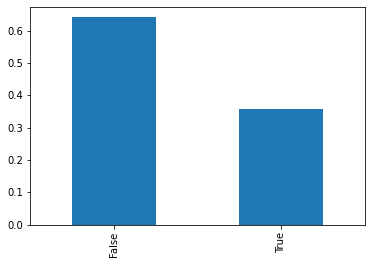

In [75]:
flights["Delay"].value_counts(normalize=True).plot.bar()

#### Around 35% of all flights have some delay

### Percentage of flights delayed by airline

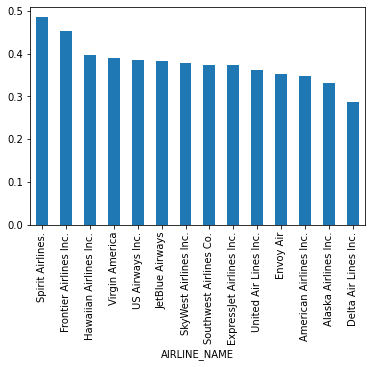

In [76]:
flights.groupby("AIRLINE_NAME").mean()["Delay"].sort_values(ascending=False).plot.bar()

### Which airlines have the most flights?

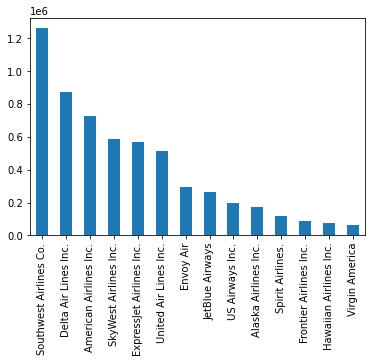

In [78]:
flights["AIRLINE_NAME"].value_counts().plot.bar()

### Which cities have the most traffic?

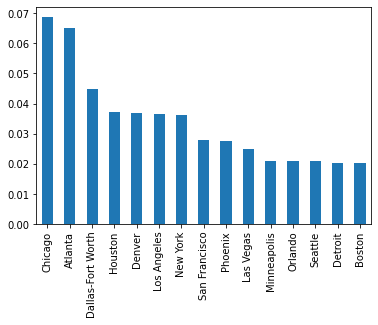

In [79]:
flights["CITY"].value_counts(normalize=True)[0:15].plot.bar()

### Which day of the week has the most traffic?

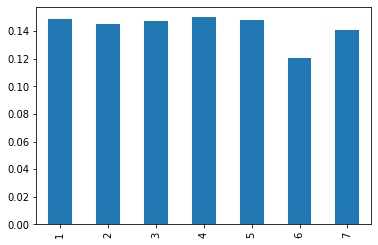

In [80]:
flights["DAY_OF_WEEK"].value_counts(normalize=True).sort_index().plot.bar()

### Which day of the week has the most delays?

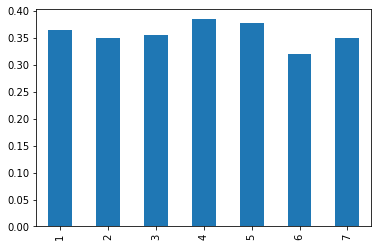

In [81]:
(flights[flights["Delay"] == True]["DAY_OF_WEEK"].value_counts().sort_index()/flights["DAY_OF_WEEK"].value_counts().sort_index()).plot.bar()

### Which month has the most delays?

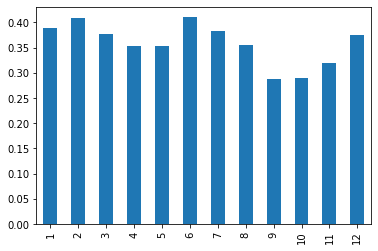

In [82]:
(flights[flights["Delay"] == True]["MONTH"].value_counts().sort_index()/flights["MONTH"].value_counts().sort_index()).plot.bar()

#### Wednesday seems to be the day with the most delays and July the month with the most delays.

### Which month has the most traffic?

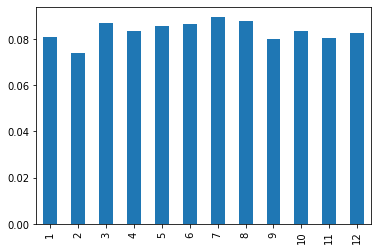

In [83]:
flights["MONTH"].value_counts(normalize=True).sort_index().plot.bar()

### Histogram of the delay times in minutes.

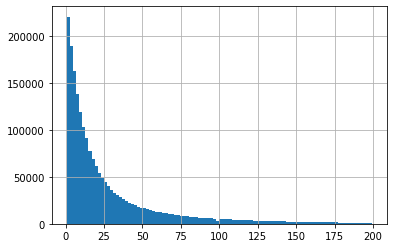

In [84]:
flights[(flights["Delay"] == True) & (flights["Delay_time"] < 200)]["Delay_time"].hist(bins=100)

### The most common departure times.

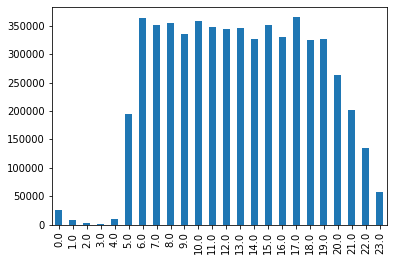

In [85]:
flights["dep_time"].dt.components["hours"].value_counts().sort_index().plot.bar()

### FLights delayed by departure time

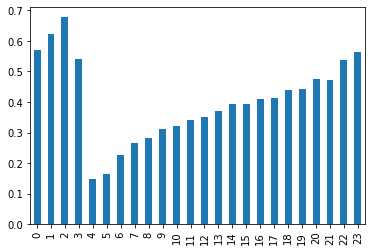

In [86]:
(flights[flights["Delay"] == True]["dep_time"].dt.components["hours"].value_counts()/flights["dep_time"].dt.components["hours"].value_counts()).sort_index().plot.bar()

There's an interesting trend here, the later into the night a plane departs, the more likely it is to be delayed

### Number of flights by arrival time

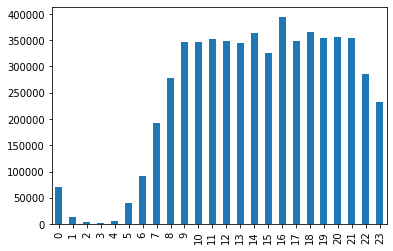

In [87]:
flights["arr_time"].dt.components["hours"].value_counts().sort_index().plot.bar()

### Percentage of flights delayed by arrival time

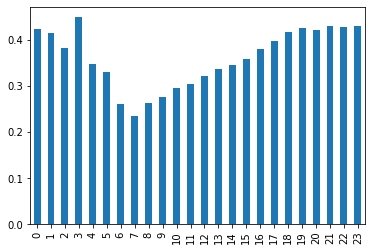

In [88]:
(flights[flights["Delay"] == True]["arr_time"].dt.components["hours"].value_counts()/flights["arr_time"].dt.components["hours"].value_counts()).sort_index().plot.bar()

## DATA CLEANING

In [89]:
flights.head().T

0  ...                     4
YEAR                                       2015  ...                  2015
MONTH                                         1  ...                     1
DAY                                           1  ...                     1
DAY_OF_WEEK                                   4  ...                     4
AIRLINE                                      AS  ...                    AS
FLIGHT_NUMBER                                98  ...                   135
TAIL_NUMBER                              N407AS  ...                N527AS
ORIGIN_AIRPORT                              ANC  ...                   SEA
DESTINATION_AIRPORT                         SEA  ...                   ANC
SCHEDULED_DEPARTURE                           5  ...                    25
DEPARTURE_TIME                             2354  ...                    24
DEPARTURE_DELAY                             -11  ...                    -1
TAXI_OUT                                     21  ...                    11
WHEELS_OFF                                   15  ...                    35
SCHEDULED_TIME                              205  ...                   235
ELAPSED_TIME                                194  ...                   215
AIR_TIME                                    169  ...                   199
DISTANCE                                   1448  ...                  1448
WHEELS_ON                                   404  ...                   254
TAXI_IN                                       4  ...                     5
SCHEDULED_ARRIVAL                           430  ...                   320
ARRIVAL_TIME                                408  ...                   259
ARRIVAL_DELAY                               -22  ...                   -21
DIVERTED                                      0  ...                     0
CANCELLED                                     0  ...                     0
CANCELLATION_REASON                         NaN  ...                   NaN
AIR_SYSTEM_DELAY                            NaN  ...                   NaN
SECURITY_DELAY                              NaN  ...                   NaN
AIRLINE_DELAY                               NaN  ...                   NaN
LATE_AIRCRAFT_DELAY                         NaN  ...                   NaN
WEATHER_DELAY                               NaN  ...                   NaN
origin_airport       Ted Stevens Anchorage Intl  ...   Seattle Tacoma Intl
CITY                                  Anchorage  ...               Seattle
manufacturer                             BOEING  ...                BOEING
AIRLINE_NAME               Alaska Airlines Inc.  ...  Alaska Airlines Inc.
Delay                                     False  ...                 False
Delay_time                                    0  ...                     0
departure_day                                 1  ...                     1
dep_time                        0 days 23:54:00  ...       0 days 00:24:00
arr_time                        0 days 04:30:00  ...       0 days 03:20:00

[40 rows x 5 columns]

The columns we will use to predict delays

### We'll only keep the columns we deem necessary for the prediction.

In [90]:
columns = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","SCHEDULED_TIME","departure_day","DEPARTURE_TIME","Delay"]

This seems like a reasonable choice, especially since it's the information that's available to any person at the moment of booking a plane ticket

In [91]:
df = flights[columns]

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   AIRLINE              object 
 1   ORIGIN_AIRPORT       object 
 2   DESTINATION_AIRPORT  object 
 3   SCHEDULED_TIME       float64
 4   departure_day        int64  
 5   DEPARTURE_TIME       float64
 6   Delay                bool   
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 316.3+ MB


In [93]:
df = df.dropna(axis=0)

In [94]:
df['AIRLINE'] = df['AIRLINE'].astype('category').cat.codes
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype('category').cat.codes
df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype('category').cat.codes

We turn several columns into the category type to feed into the predictive algorithms

In [95]:
df

AIRLINE  ORIGIN_AIRPORT  ...  DEPARTURE_TIME  Delay
0              1             624  ...          2354.0  False
1              0             783  ...             2.0  False
2             11             885  ...            18.0   True
3              0             783  ...            15.0  False
4              1             884  ...            24.0  False
...          ...             ...  ...             ...    ...
5819074        2             783  ...          2355.0  False
5819075        2             773  ...          2355.0  False
5819076        2             773  ...          2350.0  False
5819077        2             800  ...          2353.0  False
5819078        2             773  ...            14.0   True

[5732920 rows x 7 columns]

## Predicting if a flight will be delayed or not.

In [96]:
X = df[["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","SCHEDULED_TIME","departure_day","DEPARTURE_TIME"]]
y = df["Delay"]

We want to predict if the flight will be delayed or not, so that's our Y.

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [98]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

### First Model: Linear regression 

In [99]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
classification_report(y_test, y_pred, target_names=["NOT CANCELLED", "CANCELLED"])

'               precision    recall  f1-score   support\n\nNOT CANCELLED       0.65      0.96      0.77    910564\n    CANCELLED       0.54      0.08      0.15    522666\n\n     accuracy                           0.64   1433230\n    macro avg       0.59      0.52      0.46   1433230\n weighted avg       0.61      0.64      0.54   1433230\n'

In [100]:
report = classification_report(y_test, y_pred, target_names=["NOT CANCELLED", "CANCELLED"])

In [101]:
 print(report)

               precision    recall  f1-score   support

NOT CANCELLED       0.65      0.96      0.77    910564
    CANCELLED       0.54      0.08      0.15    522666

     accuracy                           0.64   1433230
    macro avg       0.59      0.52      0.46   1433230
 weighted avg       0.61      0.64      0.54   1433230



While the accuracy may seem decent at first, it's because there's a class imbalance, with more flights not being delayed than otherwise. The regression has a terrible recall for the cancelled flights, predicting most flights are not cancelled. It can predict a mere 8% of all cancelled flights as such, which is an unneceptably bad result.

### Random Forest Classifier

With the poor performance of our LR, we now try a Random Forest Classifier with the hopes it'll improve the performance. 

In [102]:
clf = RandomForestClassifier(n_estimators=15, random_state=47).fit(X_train_scaled, y_train)
y_predicted = clf.predict(X_test_scaled)
confusion = confusion_matrix(y_test, y_predicted)


After trying with SEVERAL different n_estimators, 15 seemed to give very good results and didn't need that much computing power. Since the Dataset is huge, training takes time.

In [103]:
print('Recall: {:.3f}'.format(recall_score(y_test, y_predicted)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_predicted,average="micro")))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_predicted),average="micro"))
print('F1: {:.3f}'.format(f1_score(y_test, y_predicted,average="micro")))
confusion = confusion_matrix(y_test, y_predicted)
print(confusion)
print('Feature importances: {}'.format(clf.feature_importances_))

Recall: 0.580
Precision: 0.757
Accuracy: 0.757
F1: 0.757
[[782321 128243]
 [219650 303016]]
Feature importances: [0.02845572 0.10123018 0.1004377  0.14842961 0.29124515 0.33020164]


In [105]:
print(classification_report(y_test, y_predicted, target_names=["NOT CANCELLED", "CANCELLED"]))

               precision    recall  f1-score   support

NOT CANCELLED       0.78      0.86      0.82    910564
    CANCELLED       0.70      0.58      0.64    522666

     accuracy                           0.76   1433230
    macro avg       0.74      0.72      0.73   1433230
 weighted avg       0.75      0.76      0.75   1433230



Our results are very positive, this time we can predict 58% of the delayed flights as such, while this is nowhere near as good as 100%, anyone buying a plane ticket can have a good guess at whether their flight will be delayed or not. The information fed to this algorithm is minimal, so the results are quite good for the context.

## Conclusions

Much better results could be had with further information, specially if we had some sort of weather prediction information. But for this to work properly, we would need to work near the dates of the flight to have a good predictor. Other more subtle parameters could be added to the mix, but for this we would need more information that's not available to the public. 

For people with this information and a much higher computing power, I assume a great accuracy could be reach when predicting delays in flight that could help solve the problem if seriously taken.